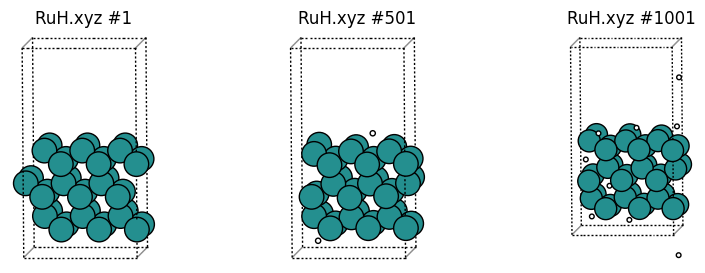

In [1]:
from common import plot_trajectory
plot_trajectory("trajectories/RuH.xyz");

Let's distinguish atoms based on whether they are H or Ru, and whether their z coordinate is greater or less than 6 angstrom.

Backslashes can be used as on the PrintGroup line to make it clearer which group is printed as which chemical element.

This example illustrates the ``REGION``, where you can use combinations of ``MinX``, ``MinY``, ``MinZ``, ``MaxX``, ``MaxY``, and ``MaxZ``.

If also illustrates ``INTERSECTION``, which takes the intersection of two or more groups.

In [2]:
%%sh
cat > cc1.config <<EOF
DumpFile trajectories/RuH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 200

DefineGroup Z_gt_6 REGION MinZ 6
DefineGroup Z_lt_6 REGION MaxZ 6
DefineGroup Ru ATOMICNUMBER Ru
DefineGroup H ATOMICNUMBER H

DefineGroup H_z_gt_6 INTERSECTION H Z_gt_6
DefineGroup H_z_lt_6 INTERSECTION H Z_lt_6
DefineGroup Ru_z_gt_6 INTERSECTION Ru Z_gt_6
DefineGroup Ru_z_lt_6 INTERSECTION Ru Z_lt_6

PrintGroup All XYZ z6.xyz SPECIAL \
    H_z_gt_6 H \
    H_z_lt_6 Li \
    Ru_z_gt_6 Cu \
    Ru_z_lt_6 Ru

EOF
OMP_NUM_THREADS=1 lionanalysis.exe cc1.config 

DumpFile trajectories/RuH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 200
DefineGroup Z_gt_6 REGION MinZ 6
DefineGroup Z_lt_6 REGION MaxZ 6
DefineGroup Ru ATOMICNUMBER Ru
DefineGroup H ATOMICNUMBER H
DefineGroup H_z_gt_6 INTERSECTION H Z_gt_6
DefineGroup H_z_lt_6 INTERSECTION H Z_lt_6
DefineGroup Ru_z_gt_6 INTERSECTION Ru Z_gt_6
DefineGroup Ru_z_lt_6 INTERSECTION Ru Z_lt_6
PrintGroup All XYZ z6.xyz SPECIAL     H_z_gt_6 H     H_z_lt_6 Li     Ru_z_gt_6 Cu     Ru_z_lt_6 Ru
###########################################################
Running on 1 threads on host .SCMCoffee1
There are 9 groups and 10 actions.
I am lionanalysis version 0.5
Opening dumpfile trajectories/RuH.xyz at byte 0 : 0
      -999       (1) (       0 ps) (5.50747e-05 s) (  0.0877 %)
      -800       (200) (     199 ps) (0.019080162 s) (      19 %)
      -600       (400) (     399 ps) (0.039276123 s) (    39.1 %)
      -400       (600) (     599 ps) (0.05884409 s) (    58.7 %)
      -200       (800) (     799 ps) (

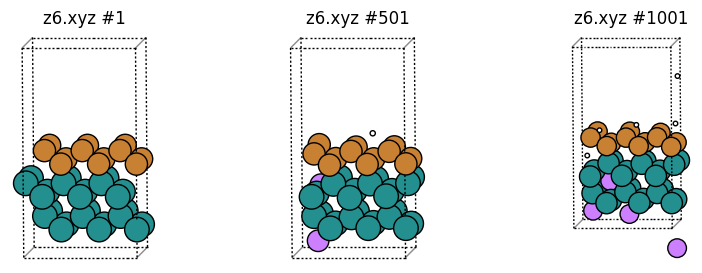

In [3]:
plot_trajectory("z6.xyz");

## Number density of particles for an axis

In [4]:
%%sh
cat > cc2.config <<EOF
DumpFile trajectories/RuH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 200

DefineGroup Ru ATOMICNUMBER Ru
DefineGroup H ATOMICNUMBER H

Density Axis z Group H Filename density_h.txt Resolution 0.05
Density Axis z Group Ru Filename density_ru.txt Resolution 0.05
Density Axis z Group All Filename density_all.txt Resolution 0.05
Density Axis z Group H Filename density_h_noperiodic.txt Resolution 0.05 NoPeriodic
EOF
OMP_NUM_THREADS=1 lionanalysis.exe cc2.config  > cc2.out

In [5]:
!head density_ru.txt

#xyz raw rawpertimestep distfuncpertstep distfuncpertstepperarea # axis: z group: ru timesteps: 1001 avgarea: 69.3554
0 0 0 0 0
0.05 0 0 0 0
0.1 0 0 0 0
0.15 0 0 0 0
0.2 0 0 0 0
0.25 0 0 0 0
0.3 0 0 0 0
0.35 0 0 0 0
0.4 0 0 0 0


The ``rawpertimestep`` contains the average number of atoms in the group per timestep, for that particular z bin:

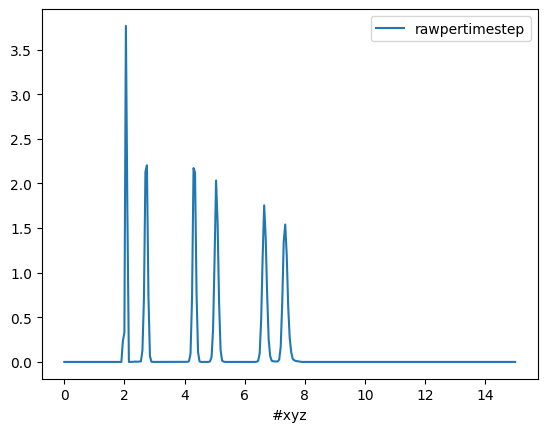

In [6]:
import pandas as pd
def density2df(filename: str) -> pd.DataFrame:
    return pd.read_csv(filename, sep="\s+").iloc[:, :5]

df = density2df("density_ru.txt")
df.plot(x="#xyz", y="rawpertimestep", kind="line");

Here, the peak at z = 2 angstrom is higher/sharper than the others, because the bottom layer was thermostatted at a much lower temperature when the MD simulation was run.

We know that there are 36 Ru atoms for all frames, so the cumulative sum should add up to 36:

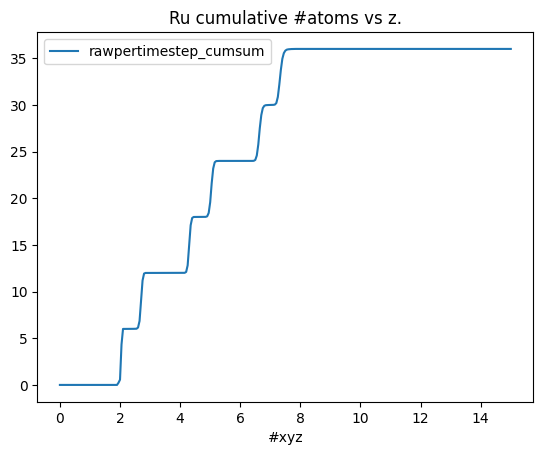

In [7]:
df["rawpertimestep_cumsum"] = df["rawpertimestep"].cumsum()
df.plot(x="#xyz", y="rawpertimestep_cumsum", kind="line", title="Ru cumulative #atoms vs z.");

However, it is usually more useful to report the **number density** as opposed to the number of particles. This number depends on both the lateral xy surface area, and the ``Resolution`` (that was set to 0.05). It is reported in the ``distfunctperstepperarea`` column.

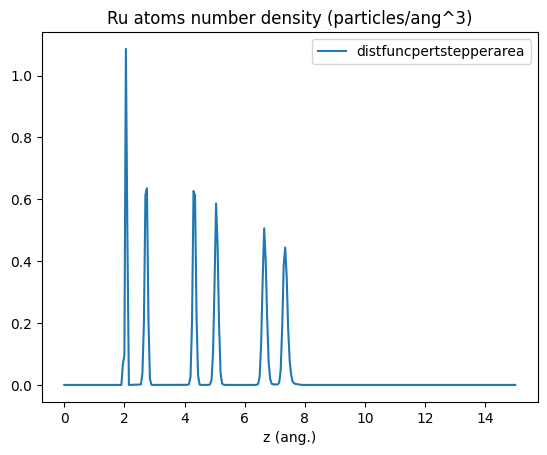

In [8]:
df.plot(x="#xyz", y="distfuncpertstepperarea", kind="line", xlabel="z (ang.)", title="Ru atoms number density (particles/ang^3)");

This relation holds:

``distfuncpertstepperarea = rawpertimestep / (Resolution * avgarea)``

where ``Resolution = 0.05`` angstrom (set in the lionanalysis input file) and ``avgarea`` is the average lateral xy surface area in ang^2. It is reported in the top line of ``density_ru.txt``:

In [9]:
%%sh
head -n 1 density_ru.txt

#xyz raw rawpertimestep distfuncpertstep distfuncpertstepperarea # axis: z group: ru timesteps: 1001 avgarea: 69.3554


**Let's compare the Ru and H number densities**:

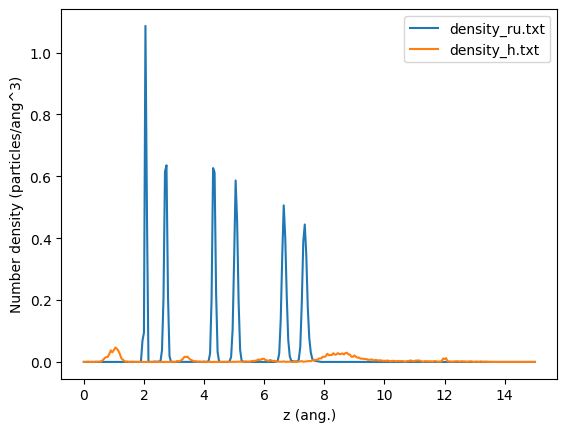

In [10]:
import matplotlib.pyplot as plt
files = ["density_ru.txt", "density_h.txt"]

fig, ax = plt.subplots()
for f in files:
    density2df(f).plot(x="#xyz", y="distfuncpertstepperarea", xlabel="z (ang.)", ylabel="Number density (particles/ang^3)", ax=ax)

ax.legend(files);

Here we see that H is primarily located on either side of the surface, with small peaks inbetween some of the Ru layers.

Finally, **let's see the effect of the NoPeriodic** option. When setting NoPeriodic, the z coordinate is not translated into the main unit cell. In this case, it means that some bins with z <0 or >15 are registered, since the trajectory contains hydrogens with those z coordinates (note: the coordinate cannot deviate more than 10 angstrom from the min/max).

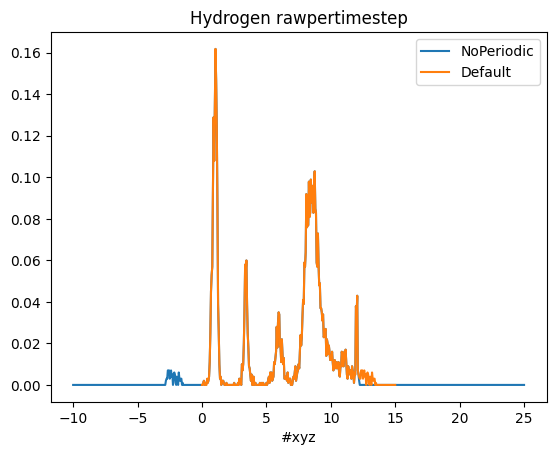

In [11]:
fig, ax = plt.subplots()
density2df("density_h_noperiodic.txt").plot(x="#xyz", y="rawpertimestep", ax=ax)
density2df("density_h.txt").plot(x="#xyz", y="rawpertimestep", ax=ax)
ax.legend(["NoPeriodic", "Default"])
ax.set_title("Hydrogen rawpertimestep");

Here we see that the trajectory contains hydrogens with z = -2 ang. (see also frame #1001 at the top of this notebook). But by default the number density will instead by shown at the other end of the unit cell, i.e., at around z=15-2=13 ang.